<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/notebooks/NLP_SMSSpan_collection_dataset_from_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.1 MB/s 
     |████████████████████████████████| 588.3 MB 7.0 kB/s 
     |████████████████████████████████| 439 kB 64.7 MB/s 
     |████████████████████████████████| 1.7 MB 50.6 MB/s 
     |████████████████████████████████| 6.0 MB 48.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
import re
import string
tfds.disable_progress_bar()

In [3]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<[^>]+>', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [5]:
def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

In [108]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) *100
  model_precision, model_recall, model_f1score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"Accuracy": model_accuracy, "Precision": model_precision, "Recall value": model_recall, "F1-Score": model_f1score}

  return model_results

In [6]:
import pandas as pd

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
path_to_dataset = tf.keras.utils.get_file("spam_dataset", url, untar=True)

203415/203415 [==============================] - 0s 0us/step


In [10]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2022-11-19 16:50:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.1s    

2022-11-19 16:50:59 (1.83 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [77]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [78]:
data_lines = get_lines("/content/SMSSpamCollection")

In [90]:
dataset = []
def pre_process_test(lines):
  for line in lines:
    lines_data = {}
    lines_data['label'] = [1 if line.split("\t")[0] == "spam" else 0][0]
    lines_data['text'] = line.split("\t")[1]
    dataset.append(lines_data)

In [91]:
pre_process_test(data_lines)

In [92]:
dataset

[{'label': 0,
  'text': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n'},
 {'label': 0, 'text': 'Ok lar... Joking wif u oni...\n'},
 {'label': 1,
  'text': "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"},
 {'label': 0, 'text': 'U dun say so early hor... U c already then say...\n'},
 {'label': 0,
  'text': "Nah I don't think he goes to usf, he lives around here though\n"},
 {'label': 1,
  'text': "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\n"},
 {'label': 0,
  'text': 'Even my brother is not like to speak with me. They treat me like aids patent.\n'},
 {'label': 0,
  'text': "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to c

In [95]:
dataset = pd.DataFrame(dataset)
dataset

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...\n
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...
5570,0,Will ü b going to esplanade fr home?\n
5571,0,"Pity, * was in mood for that. So...any other s..."
5572,0,The guy did some bitching but I acted like i'd...


In [100]:
labels = dataset['label'].to_numpy()
text_data = dataset['text'].to_numpy()


from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(text_data, labels, test_size=0.2, shuffle=True,random_state=42)
len(train_data), len(test_data), len(train_labels), len(test_labels)

(4459, 1115, 4459, 1115)

In [101]:
(test_data[10], test_labels[10])

('K, wen ur free come to my home and also tel vikky i hav sent mail to him also.. Better come evening il be free today aftr 6pm..:-)\n',
 0)

In [102]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [103]:
vectorize_layer.adapt(train_data)


In [104]:
train_sentences = tf.convert_to_tensor(train_data)
test_sentences = tf.convert_to_tensor(test_data)


In [105]:
train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

In [106]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(32)

In [107]:
embedding = layers.Embedding(max_features + 1, 128)

# Model 1

In [109]:
input = layers.Input(shape=(), dtype=tf.string)
x = vectorize_layer(input)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(input, outputs, name = "NLP_model_1")
model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_1 = model_1.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_1.name))

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.8686
Epoch 1: val_loss improved from inf to 0.39580, saving model to saved_models/NLP_model_1
140/140 [==============================] - 21s 125ms/step - loss: 0.4584 - accuracy: 0.8686 - val_loss: 0.3958 - val_accuracy: 0.8556
Epoch 2/10
139/140 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8687
Epoch 2: val_loss improved from 0.39580 to 0.38340, saving model to saved_models/NLP_model_1
140/140 [==============================] - 2s 12ms/step - loss: 0.3671 - accuracy: 0.8686 - val_loss: 0.3834 - val_accuracy: 0.8556
Epoch 3/10
137/140 [============================>.] - ETA: 0s - loss: 0.3518 - accuracy: 0.8695
Epoch 3: val_loss improved from 0.38340 to 0.36652, saving model to saved_models/NLP_model_1
140/140 [==============================] - 2s 12ms/step - loss: 0.3533 - accuracy: 0.8686 - val_loss: 0.3665 - val_accuracy: 0.8556
Epoch 4/10
139/140 [===================

In [110]:
model_1 = tf.keras.models.load_model(f"saved_models/{model_1.name}")
results = model_1.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


35/35 [==============================] - 0s 4ms/step


In [118]:
model_1_results = calculate_results(test_labels, results)
all_results = []
all_results.append(model_1_results)

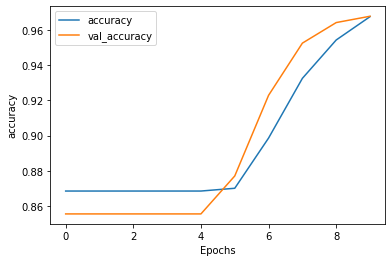

In [119]:
plot_graphs(history_1, 'accuracy')

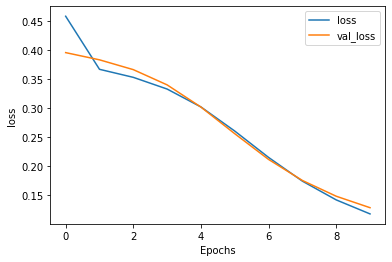

In [120]:
plot_graphs(history_1, 'loss')

# Model 2

In [115]:
input = layers.Input(shape=(), dtype=tf.string)
x = vectorize_layer(input)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(input, outputs, name = "NLP_model_2")
model_2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_2 = model_2.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_2.name))

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9089
Epoch 1: val_loss improved from inf to 0.12771, saving model to saved_models/NLP_model_2
140/140 [==============================] - 16s 107ms/step - loss: 0.2483 - accuracy: 0.9089 - val_loss: 0.1277 - val_accuracy: 0.9686
Epoch 2/10
131/140 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9814
Epoch 2: val_loss improved from 0.12771 to 0.07712, saving model to saved_models/NLP_model_2
140/140 [==============================] - 2s 13ms/step - loss: 0.0726 - accuracy: 0.9812 - val_loss: 0.0771 - val_accuracy: 0.9758
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9859
Epoch 3: val_loss improved from 0.07712 to 0.06755, saving model to saved_models/NLP_model_2
140/140 [==============================] - 3s 24ms/step - loss: 0.0472 - accuracy: 0.9859 - val_loss: 0.0675 - val_accuracy: 0.9785
Epoch 4/10
136/140 [===================

In [122]:
model_2 = tf.keras.models.load_model(f"saved_models/{model_2.name}")
results = model_2.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_2_results = calculate_results(test_labels, results)
model_2_results

35/35 [==============================] - 0s 2ms/step


{'Accuracy': 98.56502242152466,
 'Precision': 0.9855521450878877,
 'Recall value': 0.9856502242152466,
 'F1-Score': 0.9854973823019776}

In [123]:
all_results.append(model_2_results)

# Model 3

In [124]:
from tensorflow.keras import layers

input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.LSTM(units=64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(input, output, name="nlp_model_2_LSTM")
model_3.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_3 = model_3.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_3.name))

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8686
Epoch 1: val_loss improved from inf to 0.41557, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 47s 287ms/step - loss: 0.4038 - accuracy: 0.8686 - val_loss: 0.4156 - val_accuracy: 0.8556
Epoch 2/10
138/140 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8691
Epoch 2: val_loss improved from 0.41557 to 0.41452, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 15s 110ms/step - loss: 0.3919 - accuracy: 0.8686 - val_loss: 0.4145 - val_accuracy: 0.8556
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8687
Epoch 3: val_loss improved from 0.41452 to 0.41379, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 19s 137ms/step - loss: 0.3915 - accuracy: 0.8686 - val_loss: 0.4138 - val_accuracy: 0.8556
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8686
Epoch 4: val_loss improved from 0.41379 to 0.41338, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 16s 112ms/step - loss: 0.3912 - accuracy: 0.8686 - val_loss: 0.4134 - val_accuracy: 0.8556
Epoch 5/10
139/140 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8687
Epoch 5: val_loss improved from 0.41338 to 0.41324, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 17s 120ms/step - loss: 0.3911 - accuracy: 0.8686 - val_loss: 0.4132 - val_accuracy: 0.8556
Epoch 6/10
138/140 [============================>.] - ETA: 0s - loss: 0.3900 - accuracy: 0.8691
Epoch 6: val_loss improved from 0.41324 to 0.41314, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 14s 100ms/step - loss: 0.3909 - accuracy: 0.8686 - val_loss: 0.4131 - val_accuracy: 0.8556
Epoch 7/10
140/140 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8686
Epoch 7: val_loss improved from 0.41314 to 0.41306, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 12s 84ms/step - loss: 0.3908 - accuracy: 0.8686 - val_loss: 0.4131 - val_accuracy: 0.8556
Epoch 8/10
138/140 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8691
Epoch 8: val_loss improved from 0.41306 to 0.41302, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 12s 84ms/step - loss: 0.3907 - accuracy: 0.8686 - val_loss: 0.4130 - val_accuracy: 0.8556
Epoch 9/10
140/140 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8686
Epoch 9: val_loss improved from 0.41302 to 0.41298, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 13s 95ms/step - loss: 0.3906 - accuracy: 0.8686 - val_loss: 0.4130 - val_accuracy: 0.8556
Epoch 10/10
139/140 [============================>.] - ETA: 0s - loss: 0.3903 - accuracy: 0.8687
Epoch 10: val_loss improved from 0.41298 to 0.41296, saving model to saved_models/nlp_model_2_LSTM


140/140 [==============================] - 13s 90ms/step - loss: 0.3906 - accuracy: 0.8686 - val_loss: 0.4130 - val_accuracy: 0.8556


In [125]:
model_3 = tf.keras.models.load_model(f"saved_models/{model_3.name}")
results = model_3.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_3_results = calculate_results(test_labels, results)
model_3_results

35/35 [==============================] - 1s 12ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 85.56053811659193,
 'Precision': 0.732060568280078,
 'Recall value': 0.8556053811659193,
 'F1-Score': 0.7890261320756761}

In [ ]:
all_results.append(model_3_results)

# Model 4

In [126]:
input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(input, output, name="nlp_model_3_GRU")
model_4.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_4 = model_4.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_4.name))

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8686
Epoch 1: val_loss improved from inf to 0.41502, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 35s 210ms/step - loss: 0.4055 - accuracy: 0.8686 - val_loss: 0.4150 - val_accuracy: 0.8556
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8686
Epoch 2: val_loss improved from 0.41502 to 0.41459, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 17s 120ms/step - loss: 0.3928 - accuracy: 0.8686 - val_loss: 0.4146 - val_accuracy: 0.8556
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8686
Epoch 3: val_loss did not improve from 0.41459
140/140 [==============================] - 4s 32ms/step - loss: 0.3928 - accuracy: 0.8686 - val_loss: 0.4153 - val_accuracy: 0.8556
Epoch 4/10
139/140 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8687
Epoch 4: val_loss did not improve from 0.41459
140/140 [==============================] - 4s 31ms/step - loss: 0.3920 - accuracy: 0.8686 - val_loss: 0.4147 - val_accuracy: 0.8556
Epoch 5/10
140/140 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.8686
Epoch 5: val_loss improved from 0.41459 to 0.41458, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 17s 122ms/step - loss: 0.3918 - accuracy: 0.8686 - val_loss: 0.4146 - val_accuracy: 0.8556
Epoch 6/10
139/140 [============================>.] - ETA: 0s - loss: 0.3914 - accuracy: 0.8687
Epoch 6: val_loss did not improve from 0.41458
140/140 [==============================] - 5s 39ms/step - loss: 0.3916 - accuracy: 0.8686 - val_loss: 0.4147 - val_accuracy: 0.8556
Epoch 7/10
140/140 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8686
Epoch 7: val_loss improved from 0.41458 to 0.41376, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 18s 125ms/step - loss: 0.3915 - accuracy: 0.8686 - val_loss: 0.4138 - val_accuracy: 0.8556
Epoch 8/10
139/140 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8687
Epoch 8: val_loss improved from 0.41376 to 0.41357, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 20s 141ms/step - loss: 0.3913 - accuracy: 0.8686 - val_loss: 0.4136 - val_accuracy: 0.8556
Epoch 9/10
139/140 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8687
Epoch 9: val_loss improved from 0.41357 to 0.41345, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 28s 201ms/step - loss: 0.3911 - accuracy: 0.8686 - val_loss: 0.4135 - val_accuracy: 0.8556
Epoch 10/10
140/140 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8686
Epoch 10: val_loss improved from 0.41345 to 0.41343, saving model to saved_models/nlp_model_3_GRU


140/140 [==============================] - 24s 171ms/step - loss: 0.3911 - accuracy: 0.8686 - val_loss: 0.4134 - val_accuracy: 0.8556


In [127]:
model_4 = tf.keras.models.load_model(f"saved_models/{model_4.name}")
results = model_4.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_4_results = calculate_results(test_labels, results)
model_4_results

35/35 [==============================] - 2s 22ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 85.56053811659193,
 'Precision': 0.732060568280078,
 'Recall value': 0.8556053811659193,
 'F1-Score': 0.7890261320756761}

In [128]:
all_results.append(model_4_results)

# Model 5

In [129]:
input = layers.Input(shape=(), dtype="string")
x = vectorize_layer(input)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(input, output, name="nlp_model_4_BI_LSTM")
model_5.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_5 = model_5.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_5.name))

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9610
Epoch 1: val_loss improved from inf to 0.07365, saving model to saved_models/nlp_model_4_BI_LSTM


140/140 [==============================] - 51s 302ms/step - loss: 0.1192 - accuracy: 0.9610 - val_loss: 0.0737 - val_accuracy: 0.9803
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9937
Epoch 2: val_loss improved from 0.07365 to 0.05877, saving model to saved_models/nlp_model_4_BI_LSTM


140/140 [==============================] - 29s 206ms/step - loss: 0.0249 - accuracy: 0.9937 - val_loss: 0.0588 - val_accuracy: 0.9857
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9933
Epoch 3: val_loss did not improve from 0.05877
140/140 [==============================] - 8s 55ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0613 - val_accuracy: 0.9821
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9964
Epoch 4: val_loss did not improve from 0.05877
140/140 [==============================] - 6s 43ms/step - loss: 0.0164 - accuracy: 0.9964 - val_loss: 0.0663 - val_accuracy: 0.9848
Epoch 5/10
139/140 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9971
Epoch 5: val_loss improved from 0.05877 to 0.05775, saving model to saved_models/nlp_model_4_BI_LSTM


140/140 [==============================] - 28s 202ms/step - loss: 0.0125 - accuracy: 0.9971 - val_loss: 0.0578 - val_accuracy: 0.9848
Epoch 6/10
140/140 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980
Epoch 6: val_loss did not improve from 0.05775
140/140 [==============================] - 6s 42ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0615 - val_accuracy: 0.9865
Epoch 7/10
140/140 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984
Epoch 7: val_loss did not improve from 0.05775
140/140 [==============================] - 8s 54ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0661 - val_accuracy: 0.9857
Epoch 8/10
139/140 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9993
Epoch 8: val_loss did not improve from 0.05775
140/140 [==============================] - 6s 41ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.1088 - val_accuracy: 0.9839
Epoch 9/10
140/140 [=====================

In [131]:
model_5 = tf.keras.models.load_model(f"saved_models/{model_5.name}")
results = model_5.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_5_results = calculate_results(test_labels, results)
model_5_results

35/35 [==============================] - 2s 20ms/step


{'Accuracy': 98.47533632286995,
 'Precision': 0.984883352728743,
 'Recall value': 0.9847533632286996,
 'F1-Score': 0.9844403526509884}

In [134]:
all_results.append(model_5_results)

# Model 6

In [132]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(), dtype="string")
x = vectorize_layer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, 1, activation='relu',padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation="sigmoid")(x)

model_6 = tf.keras.Model(inputs, output, name="NLP_model_5_CNN")
model_6.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_6 = model_6.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_6.name))

140/140 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9841
Epoch 1: val_loss improved from inf to 0.07074, saving model to saved_models/NLP_model_5_CNN


140/140 [==============================] - 20s 101ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.0707 - val_accuracy: 0.9821
Epoch 2/10
135/140 [===========================>..] - ETA: 0s - loss: 0.0324 - accuracy: 0.9891
Epoch 2: val_loss improved from 0.07074 to 0.06955, saving model to saved_models/NLP_model_5_CNN


140/140 [==============================] - 2s 15ms/step - loss: 0.0330 - accuracy: 0.9888 - val_loss: 0.0695 - val_accuracy: 0.9848
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9912
Epoch 3: val_loss improved from 0.06955 to 0.06923, saving model to saved_models/NLP_model_5_CNN


140/140 [==============================] - 3s 21ms/step - loss: 0.0259 - accuracy: 0.9913 - val_loss: 0.0692 - val_accuracy: 0.9865
Epoch 4/10
137/140 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9936
Epoch 4: val_loss improved from 0.06923 to 0.06853, saving model to saved_models/NLP_model_5_CNN


140/140 [==============================] - 5s 36ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.0685 - val_accuracy: 0.9874
Epoch 5/10
138/140 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9955
Epoch 5: val_loss did not improve from 0.06853
140/140 [==============================] - 2s 14ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0705 - val_accuracy: 0.9874
Epoch 6/10
136/140 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9966
Epoch 6: val_loss did not improve from 0.06853
140/140 [==============================] - 2s 11ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0764 - val_accuracy: 0.9865
Epoch 7/10
136/140 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9977
Epoch 7: val_loss did not improve from 0.06853
140/140 [==============================] - 1s 7ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0971 - val_accuracy: 0.9821
Epoch 8/10
135/140 [========================

In [133]:
model_6 = tf.keras.models.load_model(f"saved_models/{model_6.name}")
results = model_6.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_6_results = calculate_results(test_labels, results)
model_6_results

35/35 [==============================] - 0s 3ms/step


{'Accuracy': 98.7443946188341,
 'Precision': 0.9875165504667965,
 'Recall value': 0.9874439461883409,
 'F1-Score': 0.9872401634601476}

In [135]:
all_results.append(model_6_results)

# Model 7

In [136]:
from tensorflow.keras import layers
import tensorflow_hub as hub

sentence_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype="string", trainable=False)

In [137]:
model_7 = tf.keras.models.Sequential([
    sentence_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation="sigmoid")
], name="nlp_model_6_use")

model_7.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_7 = model_7.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=get_callbacks(model_7.name))

Epoch 1/10
138/140 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.9287
Epoch 1: val_loss improved from inf to 0.09724, saving model to saved_models/nlp_model_6_use
140/140 [==============================] - 21s 120ms/step - loss: 0.2659 - accuracy: 0.9289 - val_loss: 0.0972 - val_accuracy: 0.9767
Epoch 2/10
136/140 [============================>.] - ETA: 0s - loss: 0.0777 - accuracy: 0.9798
Epoch 2: val_loss improved from 0.09724 to 0.06113, saving model to saved_models/nlp_model_6_use
140/140 [==============================] - 13s 96ms/step - loss: 0.0780 - accuracy: 0.9794 - val_loss: 0.0611 - val_accuracy: 0.9839
Epoch 3/10
139/140 [============================>.] - ETA: 0s - loss: 0.0562 - accuracy: 0.9840
Epoch 3: val_loss improved from 0.06113 to 0.05011, saving model to saved_models/nlp_model_6_use
140/140 [==============================] - 17s 125ms/step - loss: 0.0561 - accuracy: 0.9841 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 4/10
138/140 [====

In [138]:
model_7 = tf.keras.models.load_model(f"saved_models/{model_7.name}")
results = model_7.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_7_results = calculate_results(test_labels, results)
model_7_results

35/35 [==============================] - 1s 10ms/step


{'Accuracy': 98.9237668161435,
 'Precision': 0.9892184618114452,
 'Recall value': 0.989237668161435,
 'F1-Score': 0.989123036726483}

In [139]:
all_results.append(model_7_results)

# Model 8

In [142]:
import tensorflow_text as text  # Registers the ops.
bert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [143]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model_8 = tf.keras.Model(inputs=[text_input], outputs = [l], name="model_8_BERT")
model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_8.fit(train_ds, epochs=5, batch_size = 32, validation_dataset=test_ds, callbacks=get_callbacks(model_8.name))

TypeError: ignored

In [ ]:
model_8 = tf.keras.models.load_model(f"saved_models/{model_8.name}")
results = model_8.predict(test_ds.map(lambda text, label: text))
results = tf.squeeze(tf.round(results))
model_8_results = calculate_results(test_labels, results)
model_8_results

In [144]:
all_results

[{'Accuracy': 96.7713004484305,
  'Precision': 0.968887077048512,
  'Recall value': 0.967713004484305,
  'F1-Score': 0.9659799094776673},
 {'Accuracy': 98.56502242152466,
  'Precision': 0.9855521450878877,
  'Recall value': 0.9856502242152466,
  'F1-Score': 0.9854973823019776},
 {'Accuracy': 85.56053811659193,
  'Precision': 0.732060568280078,
  'Recall value': 0.8556053811659193,
  'F1-Score': 0.7890261320756761},
 {'Accuracy': 85.56053811659193,
  'Precision': 0.732060568280078,
  'Recall value': 0.8556053811659193,
  'F1-Score': 0.7890261320756761},
 {'Accuracy': 98.47533632286995,
  'Precision': 0.984883352728743,
  'Recall value': 0.9847533632286996,
  'F1-Score': 0.9844403526509884},
 {'Accuracy': 98.7443946188341,
  'Precision': 0.9875165504667965,
  'Recall value': 0.9874439461883409,
  'F1-Score': 0.9872401634601476},
 {'Accuracy': 98.9237668161435,
  'Precision': 0.9892184618114452,
  'Recall value': 0.989237668161435,
  'F1-Score': 0.989123036726483}]

In [145]:
all_results = pd.DataFrame(all_results)

In [146]:
all_results

,Accuracy,Precision,Recall value,F1-Score
0,96.771300,0.968887,0.967713,0.965980
1,98.565022,0.985552,0.985650,0.985497
2,85.560538,0.732061,0.855605,0.789026
3,85.560538,0.732061,0.855605,0.789026
4,98.475336,0.984883,0.984753,0.984440
5,98.744395,0.987517,0.987444,0.987240
6,98.923767,0.989218,0.989238,0.989123


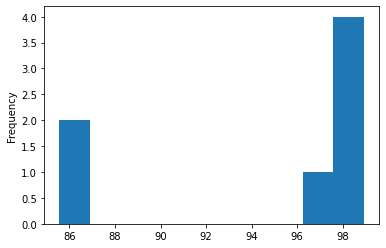

In [150]:
all_results['Accuracy'].plot(kind = 'hist')